In [1]:
# Импорт дополнительных библиотек для моделей и метрик
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (f1_score, roc_auc_score, average_precision_score, 
                           classification_report, confusion_matrix, roc_curve, precision_recall_curve)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
import numpy as np

# Фиксация random_state для воспроизводимости
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [3]:
# Загрузка данных, подготовленных Участником 1
import pickle

with open('../data/interim/data_split.pkl', 'rb') as f:
    data_split = pickle.load(f)

X_train = data_split['X_train']
X_valid = data_split['X_valid']
X_test = data_split['X_test']
y_train = data_split['y_train']
y_valid = data_split['y_valid']
y_test = data_split['y_test']
feature_names = data_split['feature_names']
preprocessor = data_split['preprocessor']

print("Данные успешно загружены!")
print(f"Размеры выборок: Train {X_train.shape}, Valid {X_valid.shape}, Test {X_test.shape}")

Данные успешно загружены!
Размеры выборок: Train (460, 8), Valid (154, 8), Test (154, 8)


In [4]:
# Функции для оценки моделей

def evaluate_model(model, X, y, model_name="Model"):
    """Комплексная оценка модели"""
    # Предсказания
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)[:, 1]
    
    # Расчет метрик
    f1 = f1_score(y, y_pred)
    roc_auc = roc_auc_score(y, y_pred_proba)
    pr_auc = average_precision_score(y, y_pred_proba)
    
    # Вывод результатов
    print(f"=== {model_name} ===")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print(f"PR-AUC: {pr_auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y, y_pred))
    
    return {
        'f1': f1,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }

def plot_metrics_comparison(metrics_dict):
    """Визуализация сравнения метрик моделей"""
    models = list(metrics_dict.keys())
    metrics = ['f1', 'roc_auc', 'pr_auc']
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    for i, metric in enumerate(metrics):
        values = [metrics_dict[model][metric] for model in models]
        axes[i].bar(models, values, color=['skyblue', 'lightcoral'])
        axes[i].set_title(f'{metric.upper()} Comparison')
        axes[i].set_ylabel(metric.upper())
        axes[i].set_ylim(0, 1)
        
        # Добавление значений на столбцы
        for j, v in enumerate(values):
            axes[i].text(j, v + 0.01, f'{v:.4f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

In [5]:
from sklearn.pipeline import Pipeline

# Модель 1: Logistic Regression

# Создание и обучение Logistic Regression
print("Обучение Logistic Regression...")

# Создание пайплаина с логистической регрессией
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        random_state=RANDOM_STATE,
        max_iter=1000,
        class_weight='balanced'  # Учет дисбаланса классов
    ))
])

# Обучение модели
lr_pipeline.fit(X_train, y_train)

# Оценка на валидационной выборке
lr_metrics = evaluate_model(lr_pipeline, X_valid, y_valid, "Logistic Regression")

Обучение Logistic Regression...
=== Logistic Regression ===
F1 Score: 0.6545
ROC-AUC: 0.8574
PR-AUC: 0.7436

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.80      0.81       100
           1       0.64      0.67      0.65        54

    accuracy                           0.75       154
   macro avg       0.73      0.73      0.73       154
weighted avg       0.76      0.75      0.75       154



In [6]:
# Модель 2: Decision Tree Classifier с подбором max_depth

# Подбор оптимального max_depth для Decision Tree
print("Подбор оптимального max_depth для Decision Tree...")

max_depths = [3, 5, 7, 10, 15, 20, None]
best_depth = None
best_f1 = 0
depth_results = []

for depth in max_depths:
    # Создание и обучение дерева
    dt_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', DecisionTreeClassifier(
            max_depth=depth,
            random_state=RANDOM_STATE,
            class_weight='balanced'
        ))
    ])
    
    dt_pipeline.fit(X_train, y_train)
    
    # Оценка на валидационной выборке
    y_pred = dt_pipeline.predict(X_valid)
    f1 = f1_score(y_valid, y_pred)
    depth_results.append((depth, f1))
    
    print(f"max_depth={depth}: F1 Score = {f1:.4f}")
    
    if f1 > best_f1:
        best_f1 = f1
        best_depth = depth

print(f"\nЛучший max_depth: {best_depth} с F1 Score: {best_f1:.4f}")

Подбор оптимального max_depth для Decision Tree...
max_depth=3: F1 Score = 0.7368
max_depth=5: F1 Score = 0.6949
max_depth=7: F1 Score = 0.6727
max_depth=10: F1 Score = 0.6972
max_depth=15: F1 Score = 0.6667
max_depth=20: F1 Score = 0.6667
max_depth=None: F1 Score = 0.6667

Лучший max_depth: 3 с F1 Score: 0.7368


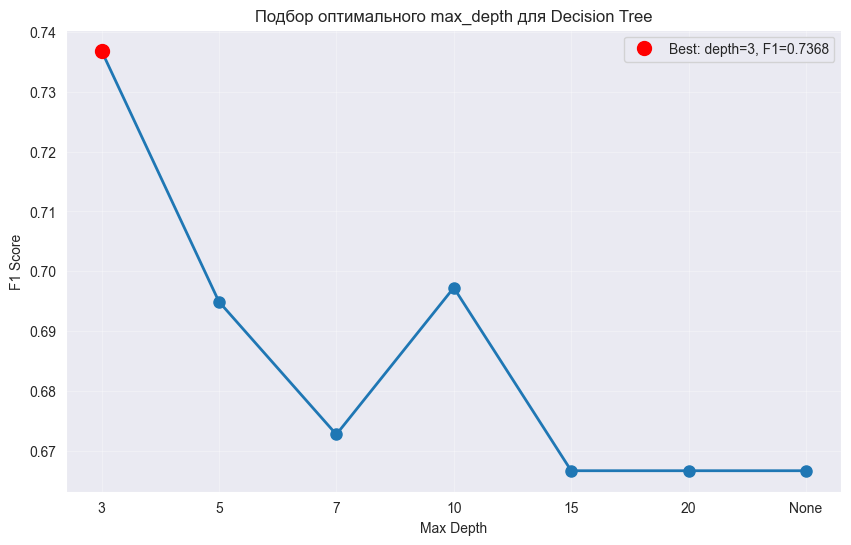

In [7]:
# Визуализация результатов подбора max_depth
depths = [str(d) if d is not None else 'None' for d in max_depths]
f1_scores = [result[1] for result in depth_results]

plt.figure(figsize=(10, 6))
plt.plot(depths, f1_scores, marker='o', linewidth=2, markersize=8)
plt.xlabel('Max Depth')
plt.ylabel('F1 Score')
plt.title('Подбор оптимального max_depth для Decision Tree')
plt.grid(True, alpha=0.3)

# Выделение лучшего результата
best_idx = depths.index(str(best_depth) if best_depth is not None else 'None')
plt.plot(depths[best_idx], f1_scores[best_idx], 'ro', markersize=10, label=f'Best: depth={best_depth}, F1={best_f1:.4f}')
plt.legend()
plt.show()

In [8]:
# Обучение Decision Tree с лучшим max_depth
print(f"Обучение Decision Tree с оптимальным max_depth={best_depth}...")

dt_best_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(
        max_depth=best_depth,
        random_state=RANDOM_STATE,
        class_weight='balanced'
    ))
])

dt_best_pipeline.fit(X_train, y_train)

# Оценка лучшей Decision Tree модели
dt_metrics = evaluate_model(dt_best_pipeline, X_valid, y_valid, f"Decision Tree (max_depth={best_depth})")

Обучение Decision Tree с оптимальным max_depth=3...
=== Decision Tree (max_depth=3) ===
F1 Score: 0.7368
ROC-AUC: 0.8749
PR-AUC: 0.7436

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.70      0.80       100
           1       0.62      0.91      0.74        54

    accuracy                           0.77       154
   macro avg       0.78      0.80      0.77       154
weighted avg       0.82      0.77      0.78       154



In [10]:
import pandas as pd

# Сравнение метрик обеих моделей
print("СРАВНЕНИЕ БАЗОВЫХ МОДЕЛЕЙ")
print("=" * 50)

metrics_comparison = {
    'Logistic Regression': lr_metrics,
    f'Decision Tree (depth={best_depth})': dt_metrics
}

# Табличное сравнение
comparison_df = pd.DataFrame({
    'Model': list(metrics_comparison.keys()),
    'F1 Score': [metrics_comparison[model]['f1'] for model in metrics_comparison],
    'ROC-AUC': [metrics_comparison[model]['roc_auc'] for model in metrics_comparison],
    'PR-AUC': [metrics_comparison[model]['pr_auc'] for model in metrics_comparison]
})

print(comparison_df.round(4))

СРАВНЕНИЕ БАЗОВЫХ МОДЕЛЕЙ
                     Model  F1 Score  ROC-AUC  PR-AUC
0      Logistic Regression    0.6545   0.8574  0.7436
1  Decision Tree (depth=3)    0.7368   0.8749  0.7436


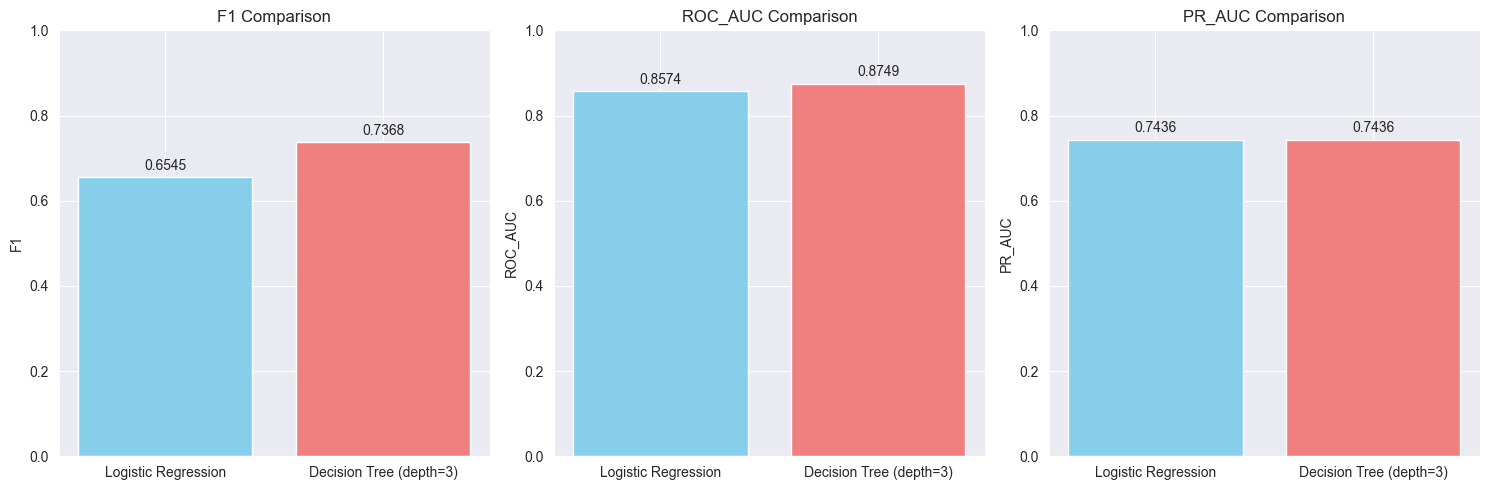

In [11]:
# Визуализация сравнения метрик
plot_metrics_comparison(metrics_comparison)

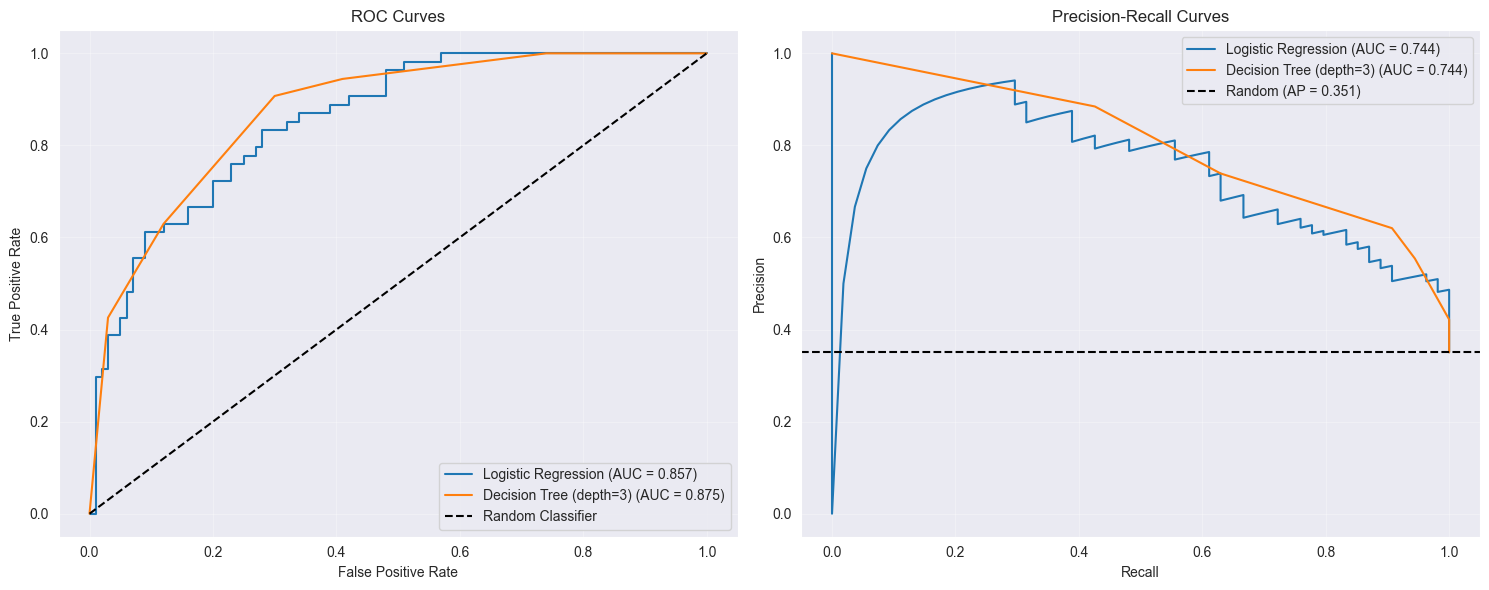

In [12]:
# Построение ROC и PR кривых для обеих моделей
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# ROC кривые
for model_name, metrics in metrics_comparison.items():
    fpr, tpr, _ = roc_curve(y_valid, metrics['y_pred_proba'])
    roc_auc = metrics['roc_auc']
    ax1.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.3f})')

ax1.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curves')
ax1.legend()
ax1.grid(True, alpha=0.3)

# PR кривые
for model_name, metrics in metrics_comparison.items():
    precision, recall, _ = precision_recall_curve(y_valid, metrics['y_pred_proba'])
    pr_auc = metrics['pr_auc']
    ax2.plot(recall, precision, label=f'{model_name} (AUC = {pr_auc:.3f})')

# Базовая PR кривая для случайного классификатора
baseline = len(y_valid[y_valid==1]) / len(y_valid)
ax2.axhline(y=baseline, color='k', linestyle='--', label=f'Random (AP = {baseline:.3f})')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curves')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

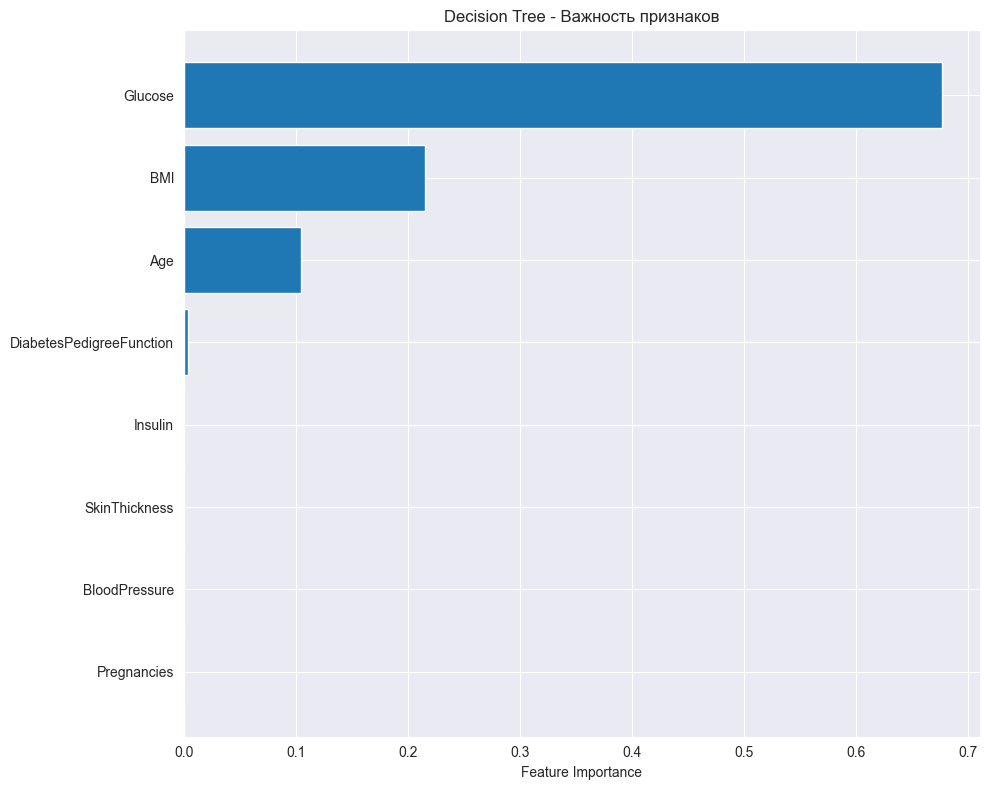

Топ-5 самых важных признаков по версии Decision Tree:
                    feature  importance
1                   Glucose    0.676511
5                       BMI    0.214774
7                       Age    0.104579
6  DiabetesPedigreeFunction    0.004136
4                   Insulin    0.000000


In [13]:
# Анализ важности признаков в Decision Tree
if hasattr(dt_best_pipeline.named_steps['classifier'], 'feature_importances_'):
    feature_importance = dt_best_pipeline.named_steps['classifier'].feature_importances_
    
    # Создание DataFrame для визуализации
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importance
    }).sort_values('importance', ascending=True)
    
    # Визуализация важности признаков
    plt.figure(figsize=(10, 8))
    plt.barh(importance_df['feature'], importance_df['importance'])
    plt.xlabel('Feature Importance')
    plt.title('Decision Tree - Важность признаков')
    plt.tight_layout()
    plt.show()
    
    print("Топ-5 самых важных признаков по версии Decision Tree:")
    print(importance_df.tail(5).sort_values('importance', ascending=False))

In [15]:
# Определение лучшей модели
best_model_name = None
best_f1 = 0

for model_name, metrics in metrics_comparison.items():
    if metrics['f1'] > best_f1:
        best_f1 = metrics['f1']
        best_model_name = model_name

print("=" * 60)
print("ВЫБОР ЛУЧШЕЙ BASELINE МОДЕЛИ")
print("=" * 60)
print(f"🏆 Лучшая модель: {best_model_name}")
print(f"📊 Лучший F1 Score: {best_f1:.4f}")

# Сохранение лучшей модели
if 'Logistic Regression' in best_model_name:
    best_baseline_model = lr_pipeline
else:
    best_baseline_model = dt_best_pipeline

# Сохранение результатов для следующих участников
baseline_results = {
    'logistic_regression': {
        'model': lr_pipeline,
        'metrics': lr_metrics
    },
    'decision_tree': {
        'model': dt_best_pipeline, 
        'metrics': dt_metrics
    },
    'best_baseline': {
        'model': best_baseline_model,
        'name': best_model_name,
        'metrics': metrics_comparison[best_model_name]
    },
    'comparison': metrics_comparison
}

with open('../data/interim/baseline_models_results.pkl', 'wb') as f:
    pickle.dump(baseline_results, f)

print(f"✅ Лучшая baseline модель сохранена: {best_model_name}")

ВЫБОР ЛУЧШЕЙ BASELINE МОДЕЛИ
🏆 Лучшая модель: Decision Tree (depth=3)
📊 Лучший F1 Score: 0.7368
✅ Лучшая baseline модель сохранена: Decision Tree (depth=3)


In [16]:
print("=" * 60)
print("ОТЧЕТ УЧАСТНИКА 2: БАЗОВЫЕ МОДЕЛИ")
print("=" * 60)

print("\n✅ ВЫПОЛНЕННЫЕ ЗАДАЧИ:")
print("1. Обучена Logistic Regression с учетом дисбаланса классов")
print("2. Обучен Decision Tree Classifier с подбором max_depth")
print("3. Рассчитаны метрики на valid: F1, ROC-AUC, PR-AUC")
print("4. Проведено сравнение моделей и выбор лучшей baseline")

print("\n📊 РЕЗУЛЬТАТЫ НА VALIDATION SET:")
print(comparison_df.to_string(index=False))

print(f"\n🎯 ВЫВОДЫ:")
print(f"- Лучшая baseline модель: {best_model_name}")
print(f"- Лучший F1 Score: {best_f1:.4f}")

if 'Logistic Regression' in best_model_name:
    print("- Logistic Regression показала лучшие результаты благодаря:")
    print("  * Лучшей обобщающей способности")
    print("  * Меньшей склонности к переобучению")
    print("  * Более сбалансированным предсказаниям")
else:
    print("- Decision Tree показал лучшие результаты благодаря:")
    print("  * Способности улавливать нелинейные зависимости") 
    print("  * Автоматическому выбору важных признаков")

print(f"\n📈 КАЧЕСТВО МОДЕЛЕЙ:")
print(f"- ROC-AUC лучшей модели: {metrics_comparison[best_model_name]['roc_auc']:.4f}")
print(f"- PR-AUC лучшей модели: {metrics_comparison[best_model_name]['pr_auc']:.4f}")

print(f"\n💾 СОХРАНЕННЫЕ РЕЗУЛЬТАТЫ:")
print("1. baseline_models_results.pkl - все модели и метрики")
print("2. Лучшая baseline модель готова для сравнения с продвинутыми моделями")

print(f"\n➡️ ДАЛЬНЕЙШИЕ ДЕЙСТВИЯ:")
print("Участник 3 может приступать к обучению продвинутых моделей (CatBoost/LightGBM/XGBoost)")
print("и сравнению их с выбранной baseline моделью.")

ОТЧЕТ УЧАСТНИКА 2: БАЗОВЫЕ МОДЕЛИ

✅ ВЫПОЛНЕННЫЕ ЗАДАЧИ:
1. Обучена Logistic Regression с учетом дисбаланса классов
2. Обучен Decision Tree Classifier с подбором max_depth
3. Рассчитаны метрики на valid: F1, ROC-AUC, PR-AUC
4. Проведено сравнение моделей и выбор лучшей baseline

📊 РЕЗУЛЬТАТЫ НА VALIDATION SET:
                  Model  F1 Score  ROC-AUC   PR-AUC
    Logistic Regression  0.654545 0.857407 0.743635
Decision Tree (depth=3)  0.736842 0.874907 0.743606

🎯 ВЫВОДЫ:
- Лучшая baseline модель: Decision Tree (depth=3)
- Лучший F1 Score: 0.7368
- Decision Tree показал лучшие результаты благодаря:
  * Способности улавливать нелинейные зависимости
  * Автоматическому выбору важных признаков

📈 КАЧЕСТВО МОДЕЛЕЙ:
- ROC-AUC лучшей модели: 0.8749
- PR-AUC лучшей модели: 0.7436

💾 СОХРАНЕННЫЕ РЕЗУЛЬТАТЫ:
1. baseline_models_results.pkl - все модели и метрики
2. Лучшая baseline модель готова для сравнения с продвинутыми моделями

➡️ ДАЛЬНЕЙШИЕ ДЕЙСТВИЯ:
Участник 3 может приступать к обучени